This notebook is following the direction and notes of: https://github.com/prateekjoshi565/movie_genre_prediction/blob/master/Movie_Genre_Prediction.ipynb

We will start by importing the required libraries. 

In [3]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

### Load Data


In [4]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Lambda-School-Labs/Labs25-Human_Rights_First-TeamC-DS/main/dbsetup/training_data.csv', na_values=False)

In [5]:
df = df.drop(columns=df.columns[0])

df.head()

,STATE_NAME,edit_at,CITY,text,date,id,STATE_CODE,COUNTY,LATITUDE,LONGITUDE,human_tags,force_tags,links
0,Louisiana,https://github.com/2020PB/police-brutality/blob/master/reports/Louisiana.md,New Orleans,police throw tear gas at protesters on a bridge,6/3/2020,la-neworleans-1,LA,Jefferson,29.963071,-90.160953,"Police, Protester",Projectiles,"['https://twitter.com/misaacstein/status/1268381797081022464', 'https://twitter.com/ckm_news/status/1268382403367763970', 'https://twitter.com/brynstole/status/1268381340073971713', 'https://twitter.com/xxnthe/status/1268427759870775298', 'https://twitter.com/greg_doucette/status/126852053839113..."
1,Texas,https://github.com/2020PB/police-brutality/blob/master/reports/Texas.md,Austin,police assault protesters,5/30/2020,tx-austin-2,TX,Hays,30.210692,-97.942749,"Police, Protester",EHC Hard Technique,"['https://gfycat.com/tautimaginativedore', 'https://www.reddit.com/r/2020PoliceBrutality/comments/hhhbeh/5302020_austin/']"
2,Texas,https://github.com/2020PB/police-brutality/blob/master/reports/Texas.md,Austin,police shoot non violent protester in the head,5/30/2020,tx-austin-3,TX,Hays,30.210692,-97.942749,"Police, Protester",Projectiles,"['https://www.reddit.com/r/PublicFreakout/comments/guwc4y/austin_tx_nonviolent_protestor_shot_in_the_head/', 'https://www.instagram.com/p/CA6TCIGnuWm/', 'https://www.youtube.com/watch?v=-BGyTi-KdKc (aftermath)', 'https://streamable.com/o1uqgy (aftermath)', 'https://cbsaustin.com/news/local/austi..."
3,Texas,https://github.com/2020PB/police-brutality/blob/master/reports/Texas.md,Austin,police use tear gas rubber bullets on protesters,5/30/2020,tx-austin-4,TX,Hays,30.210692,-97.942749,"Police, Protester",Projectiles,"['https://twitter.com/highsettler/status/1266876480929349633', 'https://imgur.com/gallery/VKuIIvu', 'https://gfycat.com/weirdthankfulgnatcatcher']"
4,Texas,https://github.com/2020PB/police-brutality/blob/master/reports/Texas.md,Austin,police open fire on crowd with rubber bullets,5/30/2020,tx-austin-5,TX,Hays,30.210692,-97.942749,Police,Projectiles,['https://twitter.com/ironfront7/status/1267133400156196870']


In [6]:
df.force_tags.head(20)

0                                   Projectiles
1                            EHC Hard Technique
2                                   Projectiles
3                                   Projectiles
4                                   Projectiles
5                                   Projectiles
6                                  Blunt Impact
7                                 Other/Unknown
8                                   Projectiles
9                                      Chemical
10                                  Projectiles
11                                  Projectiles
12                           EHC Soft Technique
13       EHC Soft Technique, EHC Hard Technique
14       EHC Soft Technique, EHC Hard Technique
15       EHC Soft Technique, EHC Hard Technique
16    EHC Soft Technique, Projectiles, Chemical
17                                 Blunt Impact
18                           EHC Hard Technique
19                                  Projectiles
Name: force_tags, dtype: object

In [7]:
df['force_tags']

0                            Projectiles
1                     EHC Hard Technique
2                            Projectiles
3                            Projectiles
4                            Projectiles
                      ...               
1034               Presence, Projectiles
1035                         Projectiles
1036               Projectiles, Chemical
1037                  EHC Soft Technique
1038    EHC Soft Technique, Blunt Impact
Name: force_tags, Length: 1039, dtype: object

In [8]:

def tags_cleaner(text):
  # remove whitespaces
    text = ' '.join(text.split())
    return text

df['tags_new_clean'] = df['force_tags'].apply(lambda x: tags_cleaner(x))
df['tags_new_clean']

0                            Projectiles
1                     EHC Hard Technique
2                            Projectiles
3                            Projectiles
4                            Projectiles
                      ...               
1034               Presence, Projectiles
1035                         Projectiles
1036               Projectiles, Chemical
1037                  EHC Soft Technique
1038    EHC Soft Technique, Blunt Impact
Name: tags_new_clean, Length: 1039, dtype: object

In [9]:
df['tags_new'] = df['tags_new_clean'].apply(lambda x: x.split(', '))
df.tags_new

0                            [Projectiles]
1                     [EHC Hard Technique]
2                            [Projectiles]
3                            [Projectiles]
4                            [Projectiles]
                       ...                
1034               [Presence, Projectiles]
1035                         [Projectiles]
1036               [Projectiles, Chemical]
1037                  [EHC Soft Technique]
1038    [EHC Soft Technique, Blunt Impact]
Name: tags_new, Length: 1039, dtype: object

Here is an overview of the police force tags that are being used on this data.

In [10]:
# get all tags in a list
tags = []

for i in df['force_tags']:
  tags.append(i)

tag_words = [word for line in tags for word in line.split(', ')]
print(len(set(tag_words)))
print(set(tag_words))

9
{'Presence', 'Chemical', 'EHC Hard Technique', 'EHC Soft Technique', 'Other/Unknown', 'Blunt Impact', 'Projectiles', 'Verbalization', 'Conductive Energy'}


In [11]:
tags = nltk.FreqDist(tag_words)
tags_df = pd.DataFrame({'Tags': list(tags.keys()), 'Count': list(tags.values())})

Sometimes visualizing data is better than putting out numbers. Let's plot the distribution of the tags.

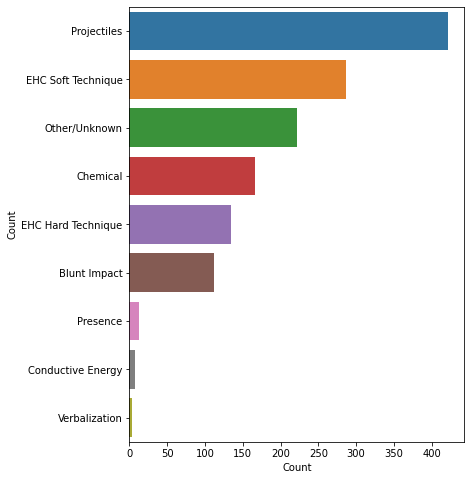

In [12]:
g = tags_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(6,8))
ax = sns.barplot(data=g, x= "Count", y = "Tags")
ax.set(ylabel = 'Count')
plt.show()

 Basic text cleaning steps..


In [13]:
# function for text cleaning
def clean_text(text):
    # remove backslash-apostrophe
    text = re.sub("\'", "", text)
    # remove everything alphabets
    text = re.sub("[^a-zA-Z]"," ",text)
    # remove whitespaces
    text = ' '.join(text.split())
    # convert text to lowercase
    text = text.lower()
    
    return text

Apply the function on the new text by using the apply-lambda duo.

In [14]:
df['new_text'] = df['text'].apply(lambda x: clean_text(x))

Here is a visual of the old text compared to the cleaned new text.This step made more sense before we cleaned the dataframe in another file first. Now its just a good habit to clean the data in my own process just in case its not clean (but as you can see, it is).

In [15]:
df[['text', 'new_text']].sample(5)

,text,new_text
619,police arrest protester without warning or clear justification,police arrest protester without warning or clear justification
776,police deploy tear gas and flashbangs against protesters,police deploy tear gas and flashbangs against protesters
570,law enforcement push and shove a crowd of protesters,law enforcement push and shove a crowd of protesters
921,protester shot in head,protester shot in head
187,federal officer tackles two protesters,federal officer tackles two protesters


In [16]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = nltk.FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(12,14))
  ax = sns.barplot(data=d, x= "count", y = "word")
  ax.set(ylabel = 'Word')
  plt.show()

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Remove the stopwords.

In [18]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
df['new_text'] = df['new_text'].apply(lambda x: remove_stopwords(x))

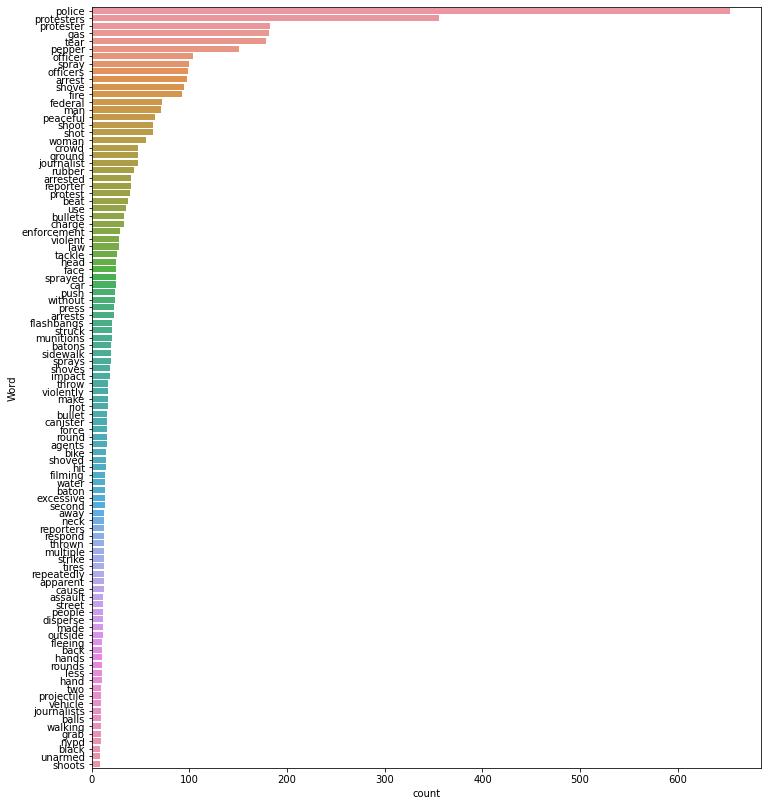

In [19]:
freq_words(df['new_text'], 100)

### Converting Text to Features

I will treat this multilable classification problem as a Binary Relevance problem. Hence, now I am going to one hot encode the target variable, i.e. *tags_new* by using sklearn's **MultiLabelBinarizer( )**. Since there are 9 unique  tags, there are going to be 9 new target variables.


In [20]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()

multilabel_binarizer.fit(df['tags_new'])
print(multilabel_binarizer.classes_)

# transform target variable

y = multilabel_binarizer.transform(df['tags_new'])

['Blunt Impact' 'Chemical' 'Conductive Energy' 'EHC Hard Technique'
 'EHC Soft Technique' 'Other/Unknown' 'Presence' 'Projectiles'
 'Verbalization']


In [21]:
print(y.shape)

(1039, 9)


We have successfully transformed the target variable and now let's turn our focus to extract features from the cleaned version of the df text. I have decided to use TF-IDF features. Any other feature extraction method such as Bag-of-Words, word2vec, GloVe, or ELMo would work. 

Learn more about different ways of creating features from text:

*   [An Intuitive Understanding of Word Embeddings: From Count Vectors to Word2Vec](https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/)
*   [A Step-by-Step NLP Guide to Learn ELMo for Extracting Features from Text](https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/)



In [22]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

Please note that I have used the 10,000 most frequent words in the data as my features. You can try any other number as well for the parameter max_features. Before creating TF-IDF features, we will split our data into train and validation sets for training our and evaluating its performance, respectively. 80% of the data samples have been kept in the train set and the rest of the data is in the validation set.

In [23]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(df['new_text'], y, test_size=0.2, random_state=9)

Now we can create features for the train and the validation set.

In [24]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

### Build the Category Prediction Model

As we have already discussed earlier, if we are using the Binary Relevance approach to solve a multilable problem, then we will have to one hot encode the target variable and then build model for each and every one hot encoded target variables. Since we have 9 target variables, we will have to fit 9 different models with the same set of predictors (TF-IDF features). 

Training 9 models can take a considerable amount of time on a modest system. I will go ahead with the Logistic Regression model as it is quick to train and easy on the limited hardware. Then I will look at SVC (Support Vector Machines) and compare.  

I have compared lr and svc. Both performed around 85%. I am going with SVC right now because lr had 0 results for the last three categories of verbalization, conductive energy and presence. I think its important that these categories get represented here.

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

We will use sklearn's OneVsRestClassifier class to solve this problem as a Binary Relevance or one-vs-all problem.

In [26]:
model = SVC()
lr = LogisticRegression()
clf = OneVsRestClassifier(model)

Finally we are going to fit our model on the train set

In [27]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='rbf', max_iter=-1,
                                  probability=False, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

Once our model is trained, we can then predict categories for the validation set. Let's do it.

In [28]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

Here is a prediction...

In [29]:
y_pred[9]

array([0, 0, 0, 1, 0, 0, 0, 0, 0])

It is a binary one dimensional array of length 32. Basically it is the one hot encoded form of the unique tags. We will have to find some way to convert it into categories. We will use **inverse_transform( )** function along with the MultiLabelBinarizer( ) object to convert the predicted arrays into tags.

In [30]:
multilabel_binarizer.inverse_transform(y_pred)[9]

('EHC Hard Technique',)

To evaluate our model's overall performance, we will have to take into consideration all the predictions and the entire target variable of the validation set.

In [31]:
# evaluate performance
f1_score(yval, y_pred, average="micro")

0.8421052631578948

In [32]:
# predict probabilities
#y_pred_prob = clf.predict_proba(xval_tfidf)


Now set a threshold value.

In [33]:
# t = 0.3 # threshold value
# y_pred_new = (y_pred_prob >= t).astype(int)

I have tried 0.3 as the threshold value. You may try any other value as well. Let's check the F1 score again on these new predictions.

In [34]:
# # evaluate performance
# f1_score(yval, y_pred_new, average="micro")

A better approach to find the right threshold value would be to use a k-fold cross validation setup and try different threshold values.

### Create Inference Function

Our job is still not over. We have trained our model and we have also made predictions for the validation set. However, we also have to take care of the new data or that would come in the future. Our prediction system should be able to take a text in raw form as input and give out its category tags as output.

To achieve this objective, let's build an inference function. It will take in a text and follow the steps below:



*   Clean the text
*   Remove stopwords from the cleaned text
*   Extract features from the text
*   Make predictions
*   Return the predicted category tags




In [35]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

Let's test this inference function on a few samples from the validation set.

In [36]:
for i in range(10):
    k = xval.sample(1).index[0]
    print("Category of Violence: ", df['text'][k], "\nPredicted category: ", infer_tags(xval[k])), print("Actual tag: ",df['force_tags'][k], "\n")   

Category of Violence:  protester shows wound inflicted by less lethal round 
Predicted category:  [()]
Actual tag:  Presence 

Category of Violence:  police fire at protesters on ground 
Predicted category:  [('Projectiles',)]
Actual tag:  Projectiles 

Category of Violence:  officer forces woman into car and wrestles with another 
Predicted category:  [('Blunt Impact',)]
Actual tag:  Blunt Impact 

Category of Violence:  police harass and assault john cusack 
Predicted category:  [('EHC Hard Technique',)]
Actual tag:  EHC Hard Technique 

Category of Violence:  tattoo artist arrested while painting the outside of his shop  police fail to deescalate 
Predicted category:  [('EHC Soft Technique',)]
Actual tag:  EHC Soft Technique 

Category of Violence:  police shove and pepper spray protesters 
Predicted category:  [('Chemical', 'EHC Soft Technique', 'Projectiles')]
Actual tag:  EHC Soft Technique, Projectiles, Chemical 

Category of Violence:  police collide with woman  she pushes back

In [37]:
df_new = df.copy()


In [38]:
df_new = df_new[['id', 'date', 'LATITUDE', 'LONGITUDE', 'new_text']]
df_new.head(5)

,id,date,LATITUDE,LONGITUDE,new_text
0,la-neworleans-1,6/3/2020,29.963071,-90.160953,police throw tear gas protesters bridge
1,tx-austin-2,5/30/2020,30.210692,-97.942749,police assault protesters
2,tx-austin-3,5/30/2020,30.210692,-97.942749,police shoot non violent protester head
3,tx-austin-4,5/30/2020,30.210692,-97.942749,police use tear gas rubber bullets protesters
4,tx-austin-5,5/30/2020,30.210692,-97.942749,police open fire crowd rubber bullets


In [39]:
new__tfidf = tfidf_vectorizer.transform(df_new['new_text'])
y_pred = clf.predict(new__tfidf)

df_new['tag_predicted'] = multilabel_binarizer.inverse_transform(y_pred)


In [40]:
df_new['tag_predicted']

0                           (Projectiles,)
1                    (EHC Hard Technique,)
2                           (Projectiles,)
3                           (Projectiles,)
4                           (Projectiles,)
                       ...                
1034                        (Projectiles,)
1035                        (Projectiles,)
1036               (Chemical, Projectiles)
1037                 (EHC Soft Technique,)
1038    (Blunt Impact, EHC Soft Technique)
Name: tag_predicted, Length: 1039, dtype: object

In [41]:
#df_new['tag_predicted'] = df_new['tag_predicted'].apply(lambda x: ', '.join(x))

In [42]:
df_new['tag_predicted'].value_counts()

(Projectiles,)                                                                   232
(EHC Soft Technique,)                                                            207
(Other/Unknown,)                                                                 191
(Chemical, Projectiles)                                                          117
()                                                                                63
(EHC Hard Technique,)                                                             60
(Blunt Impact,)                                                                   38
(Chemical, EHC Soft Technique, Projectiles)                                       22
(Blunt Impact, EHC Hard Technique)                                                21
(Blunt Impact, EHC Soft Technique)                                                18
(EHC Hard Technique, EHC Soft Technique)                                          17
(EHC Soft Technique, Projectiles)                                

In [43]:
df_newer = df_new.explode('tag_predicted')

df_newer.head(40)

,id,date,LATITUDE,LONGITUDE,new_text,tag_predicted
0,la-neworleans-1,6/3/2020,29.963071,-90.160953,police throw tear gas protesters bridge,Projectiles
1,tx-austin-2,5/30/2020,30.210692,-97.942749,police assault protesters,EHC Hard Technique
2,tx-austin-3,5/30/2020,30.210692,-97.942749,police shoot non violent protester head,Projectiles
3,tx-austin-4,5/30/2020,30.210692,-97.942749,police use tear gas rubber bullets protesters,Projectiles
4,tx-austin-5,5/30/2020,30.210692,-97.942749,police open fire crowd rubber bullets,Projectiles
5,tx-austin-8,5/30/2020,30.210692,-97.942749,pregnant woman shot bean bags police,Projectiles
6,tx-austin-10,5/30/2020,30.210692,-97.942749,police use horses weapons,Blunt Impact
7,tx-austin-1,5/31/2020,30.210692,-97.942749,police critically injure year old black protester protests police violence,Other/Unknown
8,tx-austin-6,5/31/2020,30.210692,-97.942749,police open fire crowd protester throws water,Projectiles
9,tx-austin-7,5/31/2020,30.210692,-97.942749,police spray man face stands still feet away,Chemical


In [46]:
# #pickle that data for use in other files
# import pickle
# #pickle currently used for project:
# filename = 'vect_bin_pickle.pkl'
# with open(filename, 'wb') as file:
#     pickle.dump({'clf': clf, 'tfidf': tfidf_vectorizer, 'mlb': multilabel_binarizer}, file)

## Types of force to find in data:  
Blunt Impact  
Chemical  
Conductive Energy  
EHC Hard Technique  
EHC Soft Technique  
Other/Unknown  
Presence  
Projectiles  
Verbalization